# Simulation for Recidivism Model

Previously, we've established an observation that the classification score may increase 
since the 

- prediction $h, p$ is usually positively related to $x$
- we now consider if there is a possibility that someone is actually low risk while having a criminal record


# Linear Recidivism Model

We say the recidivism is linear by saying,

- Apply the harzard model and the mix-in effect applies to $a_j, b_j$ on a basis of community
- up to now we do not assume disparity amongst groups
- we assume that there is one group
- assume the decision is a random static threshold policy

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
from recidivism import *
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import det_curve, DetCurveDisplay, roc_curve
from scipy import optimize
import warnings
warnings.filterwarnings("ignore")


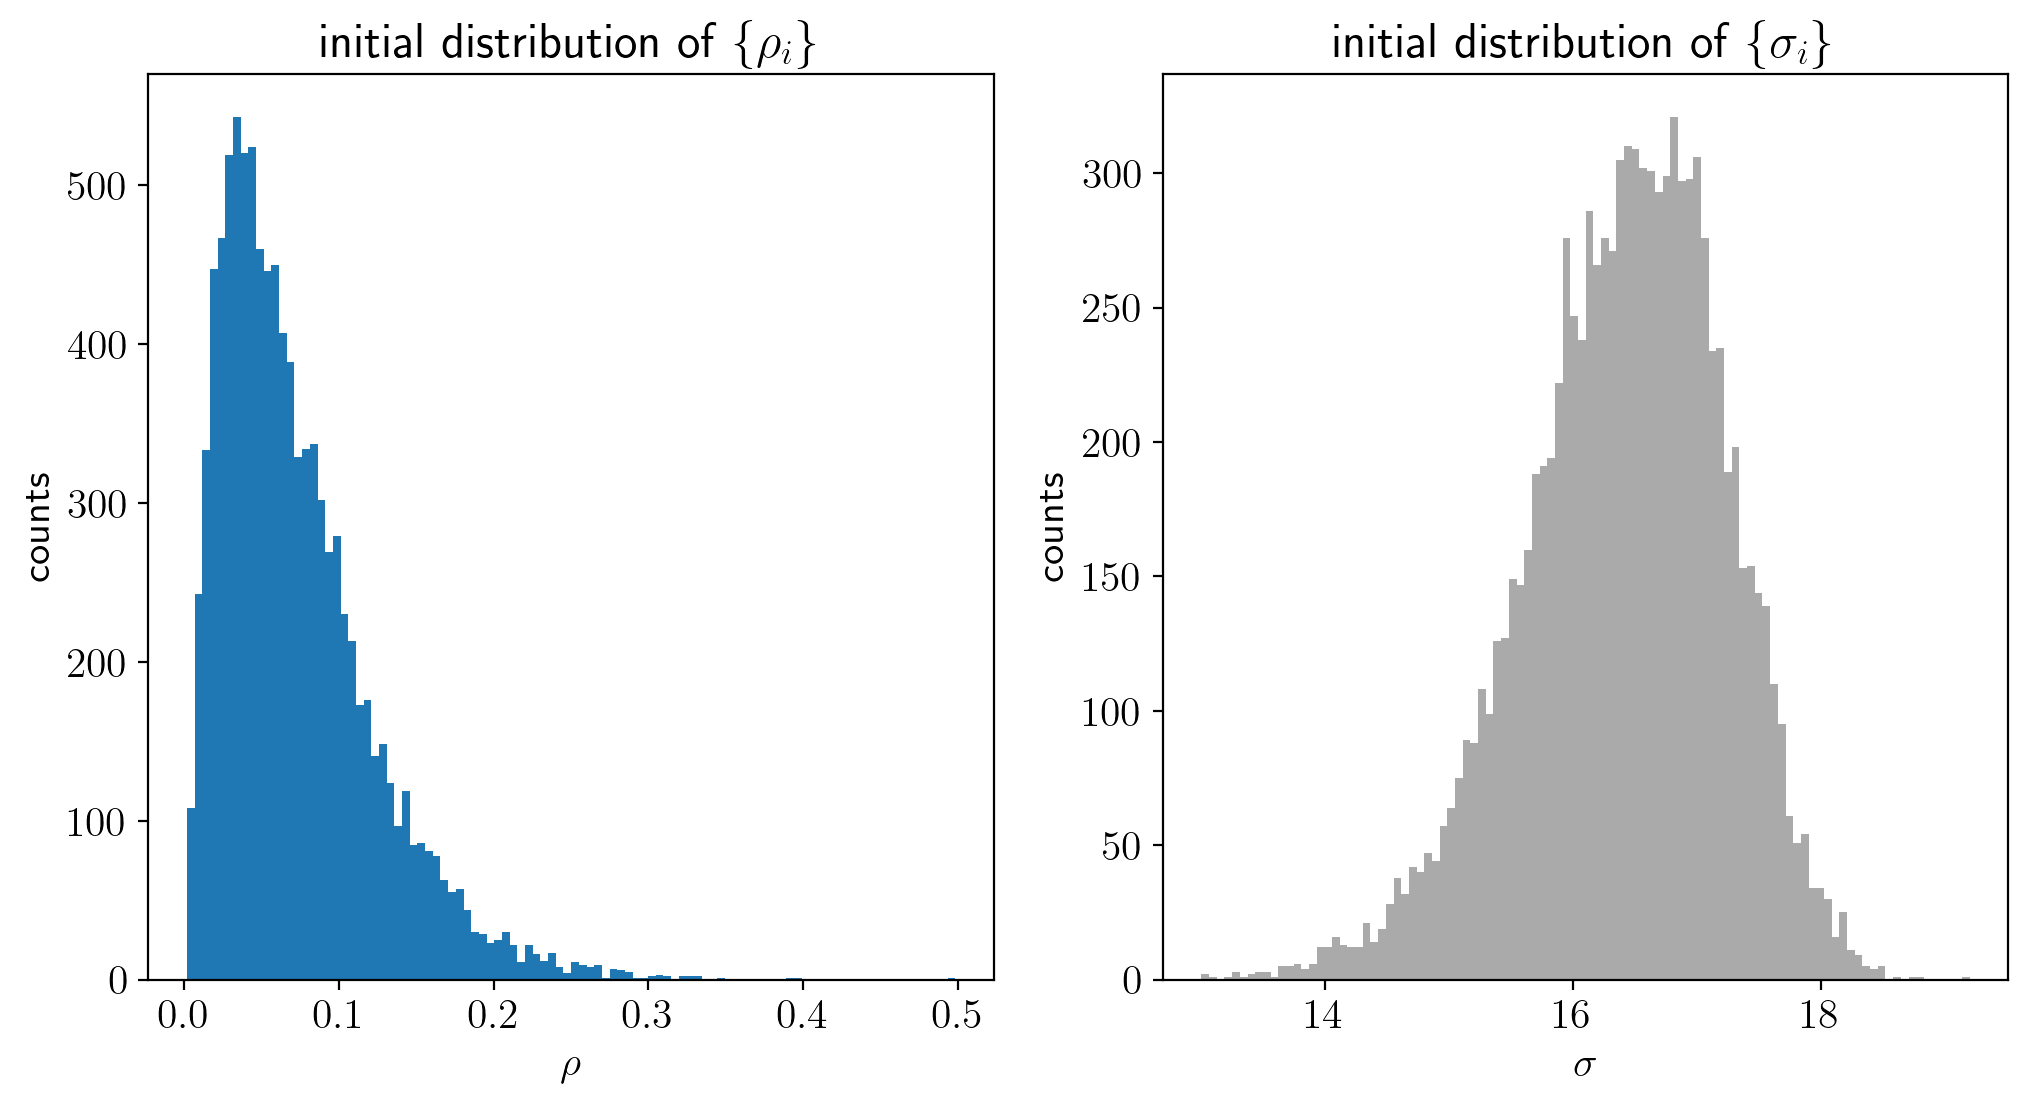

In [167]:
j = 0
n = 10000
T = 100
mode = 0
if mode == 0:
    p0 = np.random.gamma(2, 2, n) + 0.1
    p0 = p0/(p0.max() + 0.1)/2
    h = logit(p0)
    b = h.min() - 13
    a = 1
    sigma0 = (h - b)/a
else:
    pass
fig, ax = plt.subplots(nrows=1, ncols=2)
_ = ax[0].hist(p0, bins=100,)
_ = ax[1].hist(sigma0, bins=100, color="#aaaaaa")
ax[0].set_title("initial distribution of $\{\\rho_i\}$")
ax[1].set_title("initial distribution of $\{\sigma_i\}$")
ax[0].set_xlabel("$\\rho$")
ax[1].set_xlabel("$\\sigma$")
ax[0].set_ylabel("counts")
ax[1].set_ylabel("counts")
plt.savefig("./p0.png", dpi=1000)

In [4]:
######################################
# profiling tools
######################################
# P = LinearRecidProb(a, b, sigma0)
# state = GroupState(j, 1, z=None, x=np.zeros(n))
# actions = [RandomizedHierarchicalDecision(2, theta=theta) for t in range(T)]
# # %time HierarchicalDecision.func_two_way_category(state)
# # %time RandomizedHierarchicalDecision.forward(actions[0], state)
# %lprun -u 0.001 -f run run(T, P, state, actions, options=[LinearMixInType.WorsenCommunity]) 

# Setup
- Fixed policy for categorization $c$ (top-$k\%$)
- Fixed thresholds for $y$: $(\theta_1, \theta_2)$ and randomly pick

In [168]:
d = 2
space = np.linspace(0, 1.0, 20)
theta = np.array([0.1, 0.1])
grids = np.meshgrid(space, space)
idx = 1

# Stationarity of Long-Run Recidivates

1.0 1.0
0.0020077451816027407 0.49824226674462646


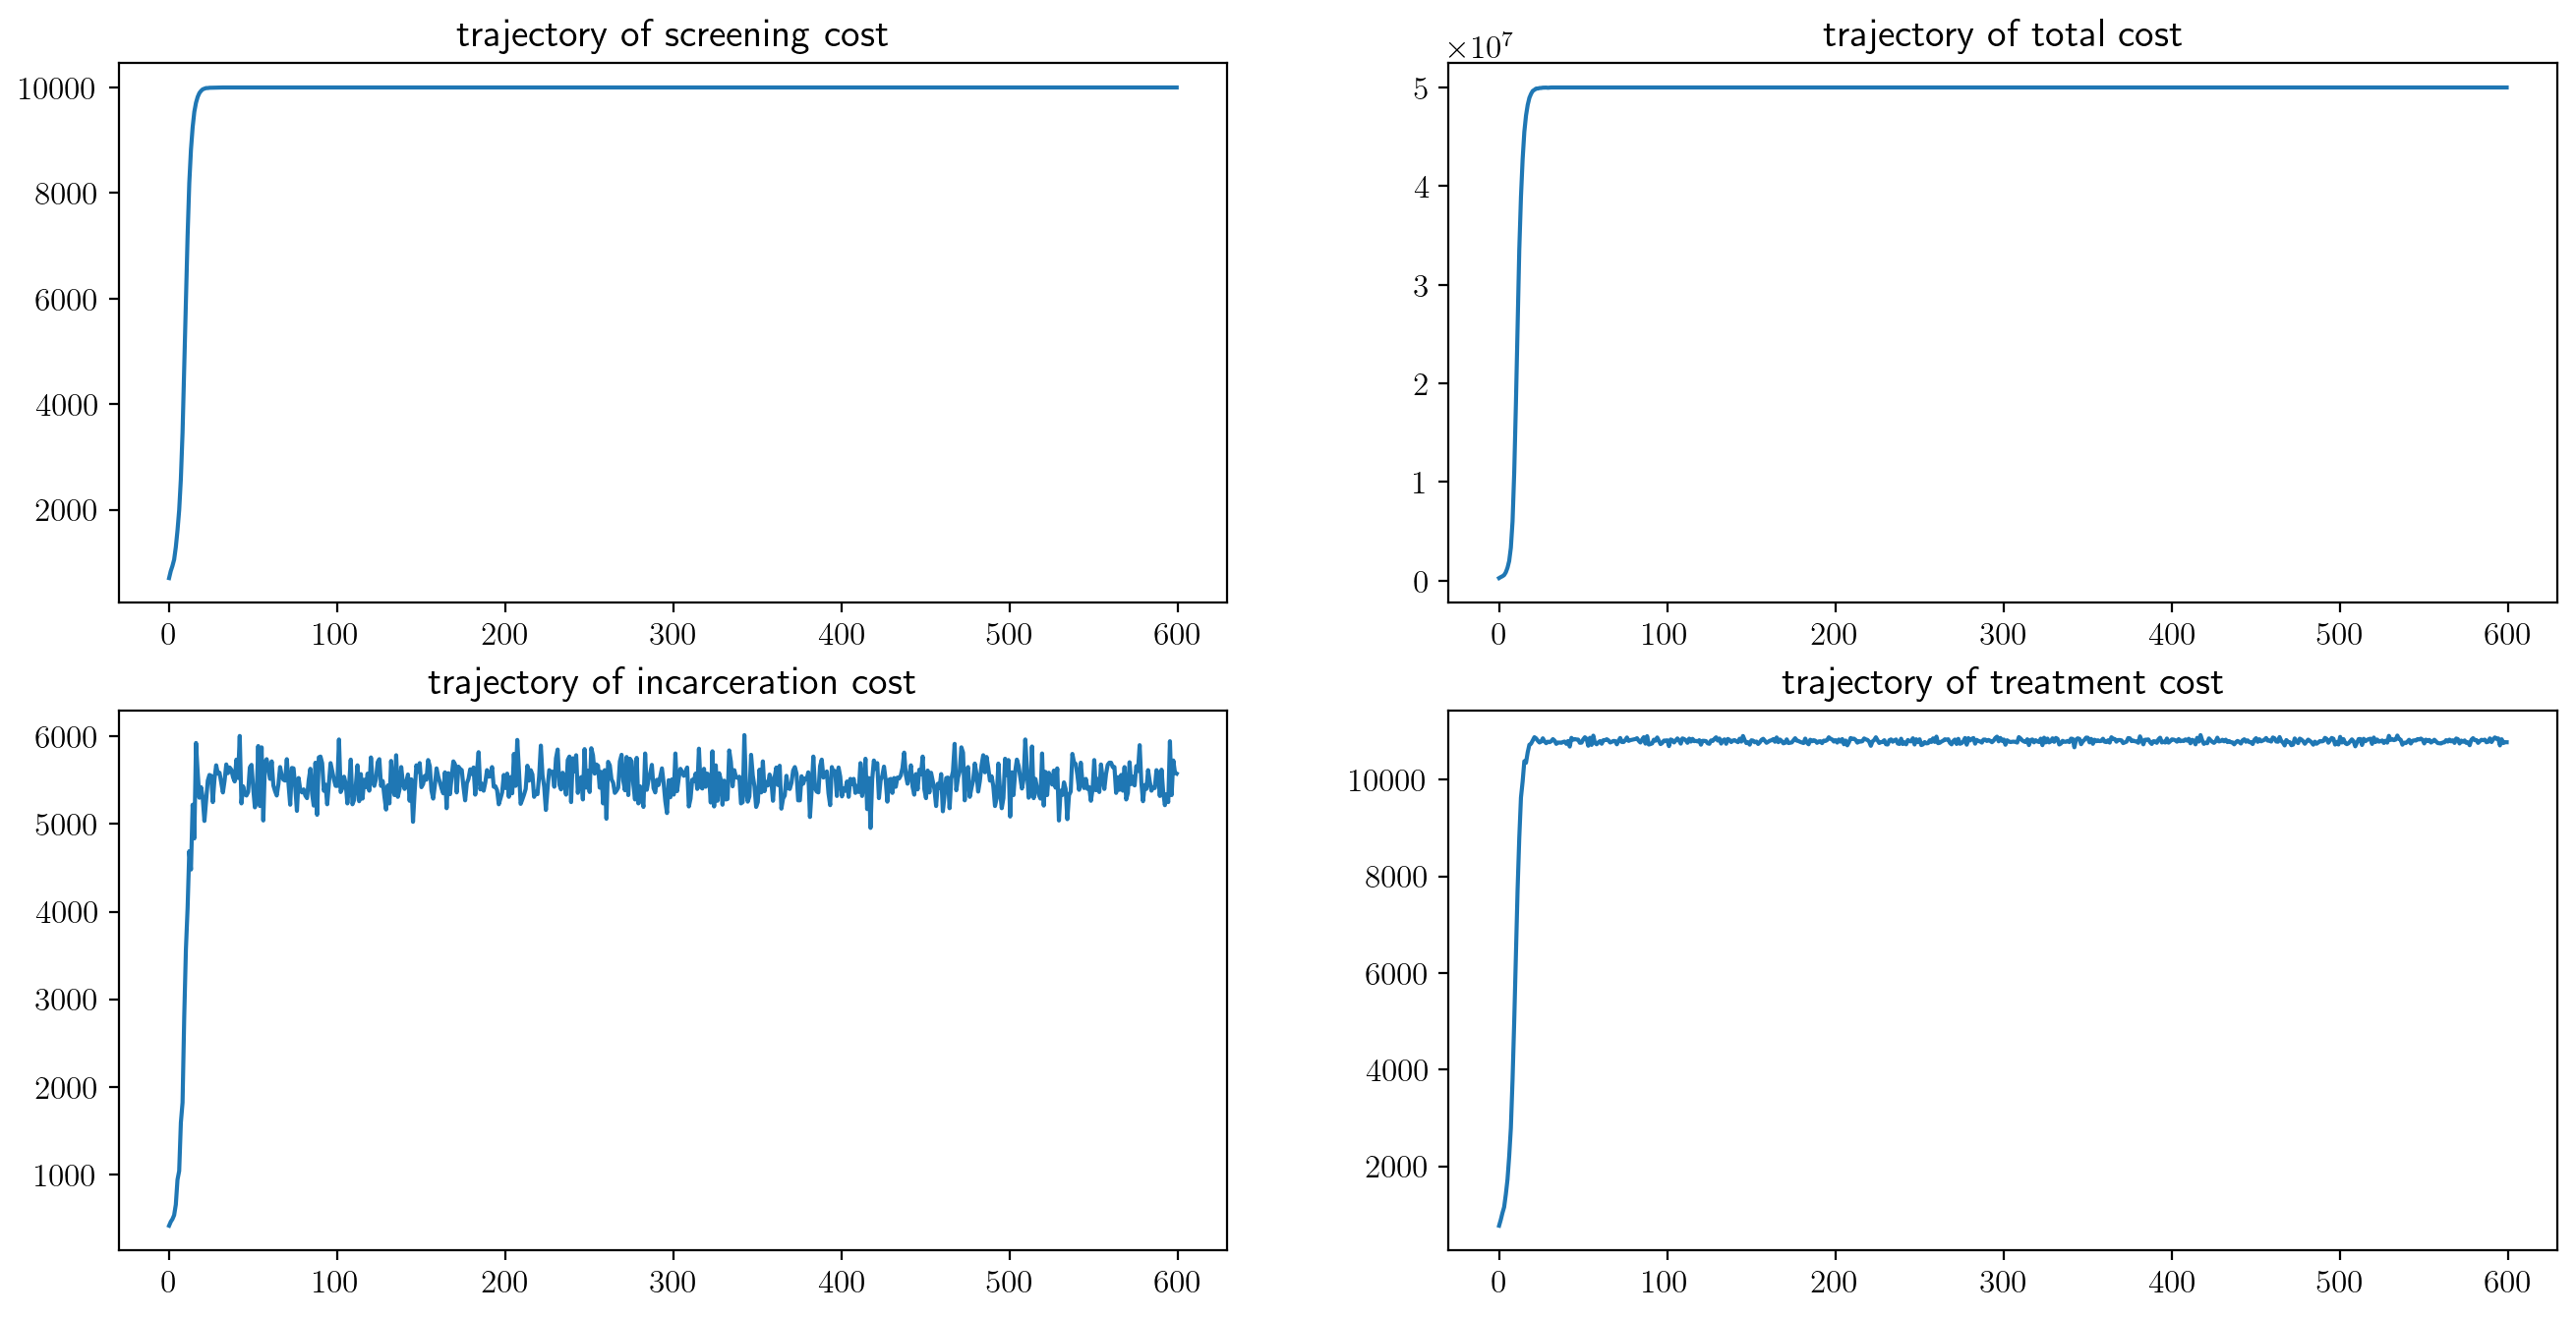

In [212]:
T = 600
options_population=[
    PopulationType.Decease
]
P = LinearRecidProb(a, b, sigma0.copy())
actions = [
    RandomizedHierarchicalDecision(d, theta=np.array([0.1, 0.1]), func="random")
    for _ in range(T)
]
state = GroupState(j, 0, z=None, x=np.zeros(n))
traj = run(
    T,
    P,
    state,
    actions=actions,
    options_mix=2,
    func_cost_function=DecisionCost.func_dual_cost,
    # options_population=[PopulationType.Decease],
    options_population=[],
    verbose=False
)
show_traj(traj)
print(P.P.min(), P.P.max())
P0 = LinearRecidProb(a, b, sigma0)
print(P0.P.min(), P0.P.max())

## Vector Plots for Equilibrium
- use random classification

- we change different records
    - zero start
    - high probability matches high
    - high probability unmatches high record

### Fixed Population

In [408]:
# high matches high
x1 = np.zeros(n)
p1 = np.random.gamma(2, 2, n) + 0.1
p1 = p1/(p1.max() + 0.1)/2
p1[0:n//10] = 0.99
x1[0:n//10] = 100
h1 = logit(p1)
b1 = h1.min() - 13
sigma1 = (h1 - b1)/a
# low matches high
x2 = np.zeros(n)
p2 = np.random.gamma(2, 2, n) + 0.1
p2 = p2/(p2.max() + 0.1)/2
p2[0:n//10] = 0.01
p2[n//10+1:-1] = 0.94
x2[0:n//10] = 100
h2 = logit(p2)
b2 = h2.min() - 13
sigma2 = (h2 - b2)/a

init_choices = [
    (np.zeros(n), LinearRecidProb(a, b, sigma0.copy())),
    (x1, LinearRecidProb(a, b1, sigma1.copy())),
    (x2, LinearRecidProb(a, b2, sigma2.copy())),
]

xy = []
uv = []
for xx, pp in init_choices:
    T = 200
    actions = [
        RandomizedHierarchicalDecision(d, theta=np.array([0.5, 0.5]), func=None)
        for _ in range(T)
    ]
    state = GroupState(j, 0, z=None, x=xx.copy())
    traj = run(
        T,
        pp,
        state,
        actions=actions,
        options_mix=2,
        func_cost_function=DecisionCost.func_dual_cost,
        # options_population=[PopulationType.Decease],
        options_population=[],
        verbose=False
    )


    for idx, s in enumerate(traj):
        # _xy_at_t = np.log2(s.a.recid_treat.sum(1))
        _xy_at_t = s.a.recid_treat.sum(1) 
        # _xy_at_t[0] = _xy_at_t[0] 
        _xy_at_prev = np.zeros(2) if idx == 0 else xy[-1]
        grad = _xy_at_t - _xy_at_prev
        
        uv.append(grad)
        xy.append(_xy_at_t)
    # break
        
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.set_xlabel("total number treated in $L$")
ax.set_ylabel("total number treated in $H$")
xy = np.vstack(xy)[2:,:]
uv = np.vstack(uv)[2:,:]
Q = ax.quiver(
    xy[:,0], xy[:,1], uv[:,0], uv[:,1], 
    units='x', pivot='tip',
    scale_units="x",
    scale=1 / 0.8,
)

plt.show()

In [409]:
fig.savefig("discrete.fix.png")

### Entrances and Exits

In [426]:
# high matches high
x1 = np.zeros(n)
p1 = np.random.gamma(2, 2, n) + 0.1
p1 = p1/(p1.max() + 0.1)/2
p1[0:n//10] = 0.99
x1[0:n//10] = 100
h1 = logit(p1)
b1 = h1.min() - 13
sigma1 = (h1 - b1)/a
# low matches high
x2 = np.zeros(n)
p2 = np.random.gamma(2, 2, n) + 0.1
p2 = p2/(p2.max() + 0.1)/2
p2[0:n//10] = 0.01
p2[n//10+1:-1] = 0.94
x2[0:n//10] = 100
h2 = logit(p2)
b2 = h2.min() - 13
sigma2 = (h2 - b2)/a

init_choices = [
    (np.zeros(n), LinearRecidProb(a, b, sigma0.copy())),
    (x1, LinearRecidProb(a, b1, sigma1.copy())),
    (x2, LinearRecidProb(a, b2, sigma2.copy())),
]

xy = []
uv = []
for xx, pp in init_choices:
    T = 200
    actions = [
        RandomizedHierarchicalDecision(d, theta=np.array([0.5, 0.5]), func=None)
        for _ in range(T)
    ]
    state = GroupState(j, 0, z=None, x=xx.copy())
    traj = run(
        T,
        pp,
        state,
        actions=actions,
        options_mix=2,
        func_cost_function=DecisionCost.func_dual_cost,
        options_population=[PopulationType.Decease],
        # options_population=[],
        verbose=False
    )


    for idx, s in enumerate(traj):
        # _xy_at_t = np.log2(s.a.recid_treat.sum(1))
        _xy_at_t = s.a.recid_treat.sum(1) 
        # _xy_at_t[0] = _xy_at_t[0] 
        _xy_at_prev = np.zeros(2) if idx == 0 else xy[-1]
        grad = _xy_at_t - _xy_at_prev
        
        uv.append(grad)
        xy.append(_xy_at_t)

In [429]:
xy.shape

(600, 2)

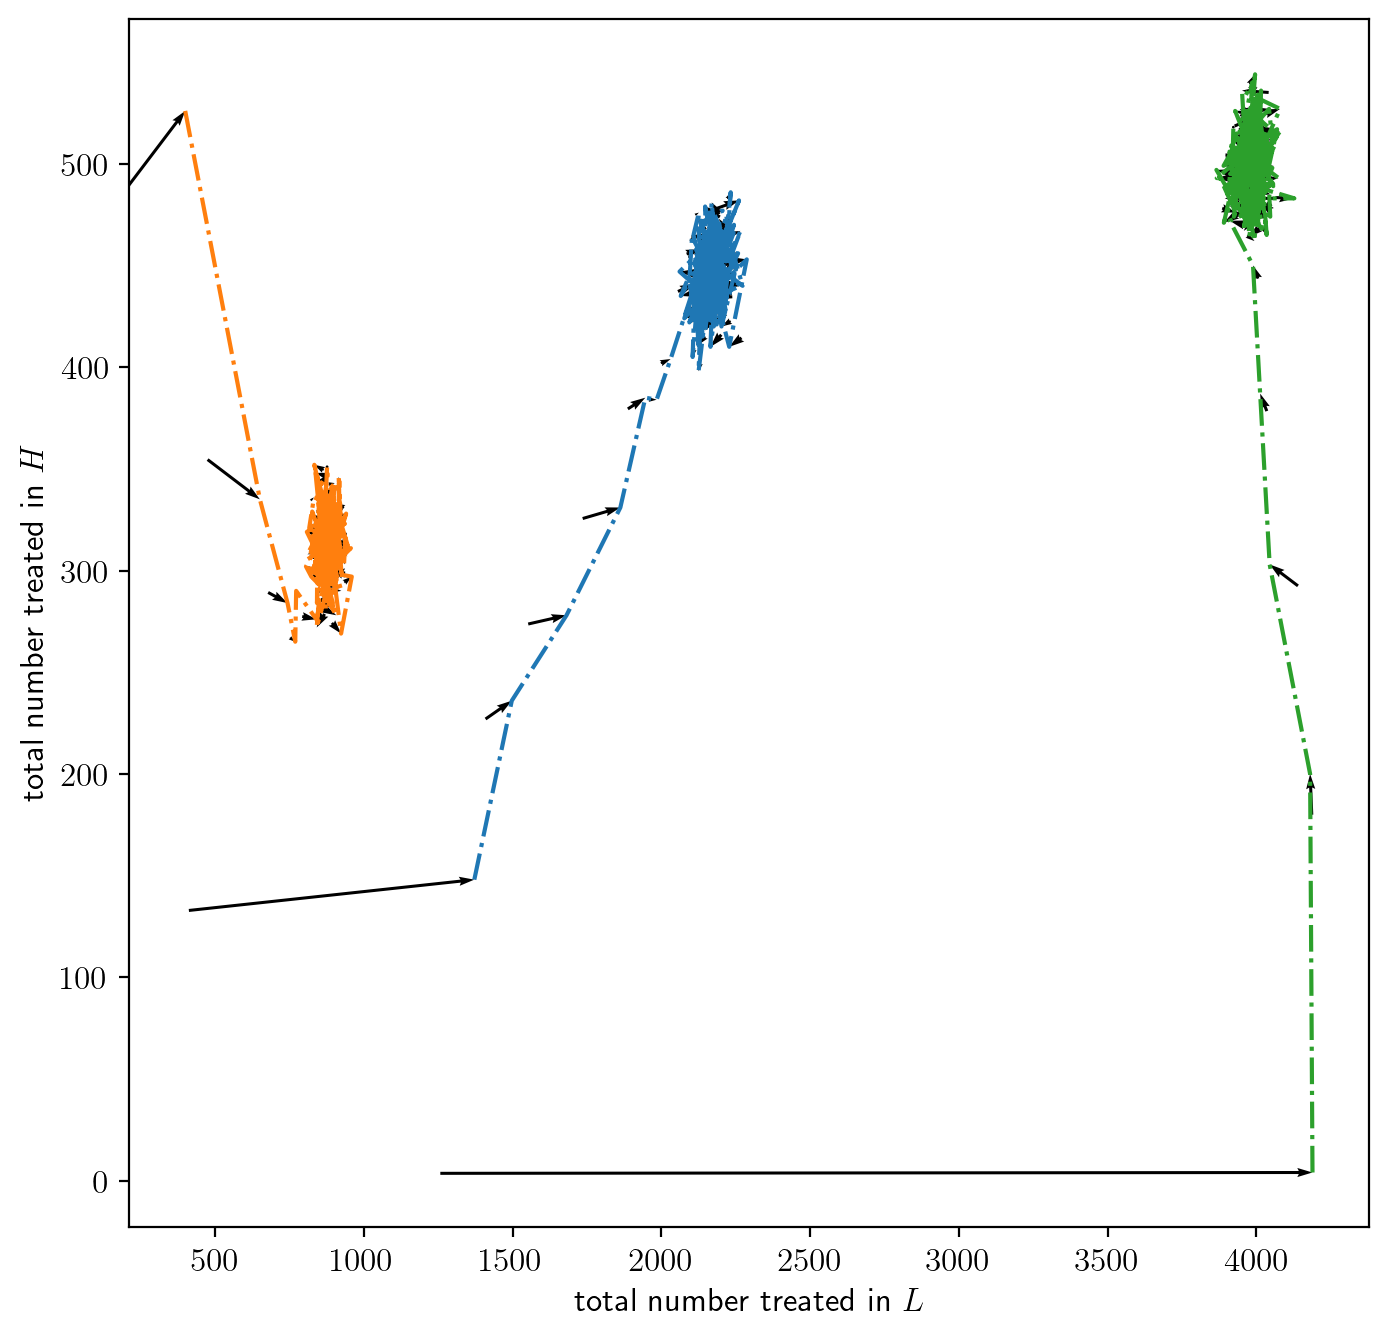

In [430]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.set_xlabel("total number treated in $L$")
ax.set_ylabel("total number treated in $H$")
xy = np.vstack(xy)[0:,:]
uv = np.vstack(uv)[0:,:]
Q = ax.quiver(
    xy[:,0], xy[:,1], uv[:,0], uv[:,1], 
    units='x', pivot='tip',
    scale_units="x",
    scale=1 / 0.7,
)

for idx, s in enumerate(traj):
    L = ax.plot(
        xy[idx*T:(idx+1)*T,0], xy[idx*T:(idx+1)*T,1], linestyle="-."
    )

plt.show()

fig.savefig("discrete.exit.png")

# Optimality by Grid Search on $\theta_1, \theta_2$

In [152]:
mode = 2

if mode == 1:
    T=100
    P = LinearRecidProb(a, b, sigma0)
    state = GroupState(j, 0, z=None, x=np.zeros(n))
    perfs = grid_search(
        state, P, T, d, 
        space, 
        run_func=run,
        options_mix=1,
        options_population=[],
        func_cost_function=DecisionCost.func_dual_cost,
    )
    
elif mode == 2:
    T=100
    P = LinearRecidProb(a, b, sigma0)
    state = GroupState(j, 0, z=None, x=np.zeros(n))
    perfs = grid_search(
        state, P, T, d, 
        space, 
        run_func=run,
        options_mix=2,
        options_population=[PopulationType.Decease],
        func_cost_function=DecisionCost.func_dual_cost,
        # options_population=[],
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [153]:
df = show_grids(grids, perfs, idx, plot=False)
df

trajectory size: 100


,r,s,f,ri,rt
0,2557439.16,1111394.92,3.320815e+11,0.00,2557439.16
1,2661653.67,1031941.72,2.857673e+11,19373.00,2238753.87
2,2546581.00,885158.69,2.090154e+11,70231.00,1784440.20
3,2717514.36,850323.12,1.944080e+11,141220.00,1629954.76
4,2659195.32,771071.05,1.583000e+11,211623.00,1379836.12
...,...,...,...,...,...
395,4645804.75,153925.59,6.326045e+09,4495699.75,1320.30
396,4651532.88,150891.99,6.081104e+09,4546941.00,664.38
397,4697108.07,148892.02,5.920070e+09,4623891.75,331.02
398,4660693.05,145317.46,5.643665e+09,4624219.50,98.55


> After some linear rescaling

trajectory size: 100


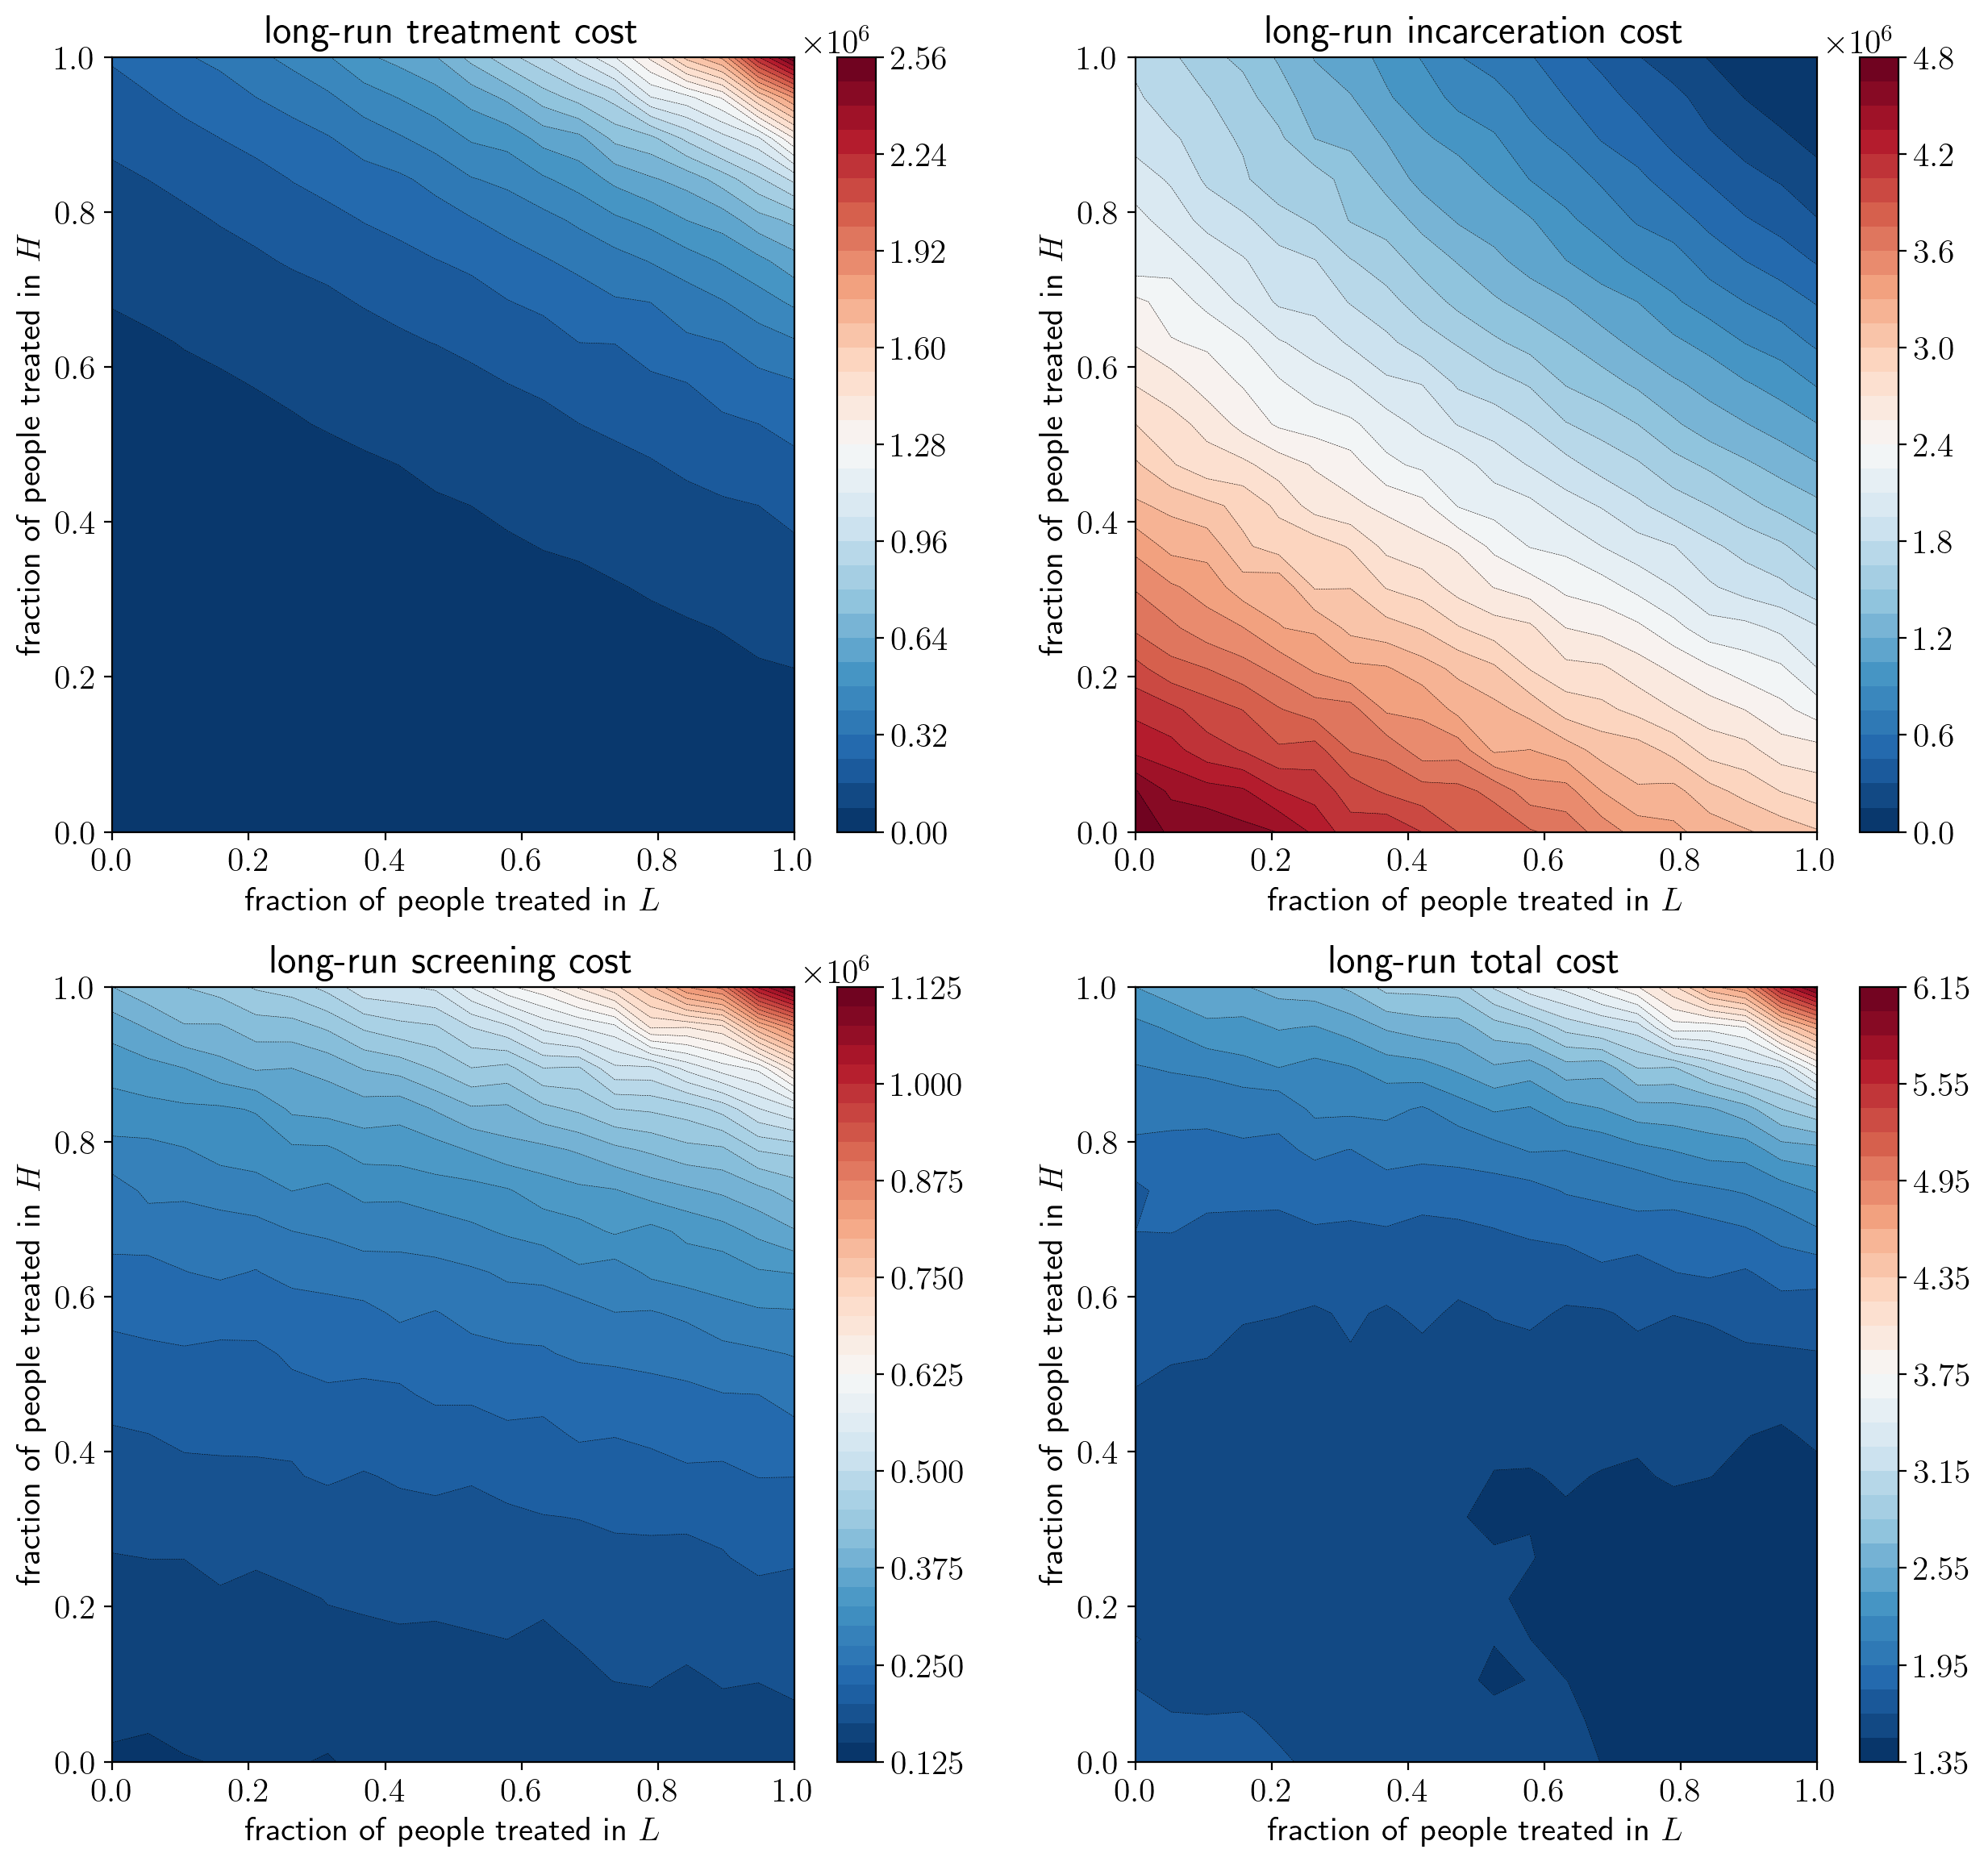

,r,s,f,ri,rt
0,2557439.16,1111394.92,6.068462,0.00,2557439.16
1,2661653.67,1031941.72,5.611334,19373.00,2238753.87
2,2546581.00,885158.69,4.796728,70231.00,1784440.20
3,2717514.36,850323.12,4.605851,141220.00,1629954.76
4,2659195.32,771071.05,4.173647,211623.00,1379836.12
...,...,...,...,...,...
395,4645804.75,153925.59,1.669032,4495699.75,1320.30
396,4651532.88,150891.99,1.663981,4546941.00,664.38
397,4697108.07,148892.02,1.669305,4623891.75,331.02
398,4660693.05,145317.46,1.651451,4624219.50,98.55


In [154]:
# rescale
df['f'] = (df['ri']/5e6 + df['rt']/5e6+ df['s']/2e+05)
df = show_grids(grids, perfs, idx, df=df)
df